# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

# 0. Importing libraries

In [1]:
colab = False

In [2]:
%%capture
if colab:
  !pip install fitter
  !pip install pydot
  !pip install graphviz

In [3]:
import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics


from fitter import Fitter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras import callbacks

from scipy import stats

2024-02-13 10:51:04.968007: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Load and inspect the dataset

## load data

In [4]:

if colab:
    # se con colab
    from pathlib import Path

    from google.colab import drive

    drive.mount('/content/drive')
    data_folder = Path.cwd() / "drive" / "MyDrive" / "A3I" / "data"
    dataset_path = data_folder.joinpath("AMS_descritt_noSM_meltD_adim.csv")
else:
    # se in locale
    dataset_path = "data/AMS_descritt_noSM_meltD_adim.csv"

df = pd.read_csv(dataset_path, sep=',', encoding='utf-8')
df.drop(df.columns[[0]], axis=1, inplace=True)
df.head()

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


In [5]:
print(df.columns)

to_remove = ['Nome', 'loc', 'scale', '99perc', '95perc', '80perc']
df_cleaned = df.drop(to_remove, axis=1, inplace=False)

df_cleaned.head()

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h],AMS,mean_IdD
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1,1.221239,28.250000
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1,0.778761,28.250000
2,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,1,1.219018,33.469565
3,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,1,0.979995,33.469565
4,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,1,1.153287,33.469565


In [6]:
# Unique duration values
DURATION = df_cleaned['duration[h]'].unique()
print(DURATION)

[ 1  3  6 12 24]


## 1.1. Preprocess the dataset

In [7]:
# create a dictionary of dataframes, one for each duration
dfs = {}
for duration in DURATION:
    dfs[f'{duration}'] = df_cleaned[df_cleaned['duration[h]'] == duration].drop("duration[h]", axis=1, inplace=False)
    dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [8]:
dfs['3']

,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,AMS,mean_IdD
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1.106796,51.500000
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,0.893204,51.500000
2,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1.184466,51.500000
3,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,0.815534,51.500000
4,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,245.328628,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,0.876011,53.195652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54923,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,0.946180,37.836364
54924,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,1.009611,37.836364
54925,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,0.459875,37.836364
54926,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,1.009611,37.836364


In [9]:
# maximum value of AMS in each dataframe
for duration in DURATION:
    print(f"maximum AMS in {duration}h: {dfs[f'{duration}']['AMS'].max()}")

maximum AMS in 1h: 4.782464297575557
maximum AMS in 3h: 4.905896003540713
maximum AMS in 6h: 5.373404747735238
maximum AMS in 12h: 5.915663202234329
maximum AMS in 24h: 6.288661312900612


## scale the columns of the df

In [10]:
def scale_AMS(df, k = 1, IdD = True):
    """
        df: dataframe
        k: Multiplication factor to extend the range of AMS values. Defaults to 1.
        IdD: To specify how standardize. Defaults to True.
    """
    if IdD:
        df['AMS'] = df.apply(lambda row: row['AMS'] * row['IdD'], axis=1)

    min_AMS = df['AMS'].min() - 1e-3 # to avoid zero values
    max_AMS = df['AMS'].max() * k

    df['AMS'] = df.apply(lambda row: (row['AMS'] - min_AMS) / (max_AMS - min_AMS), axis=1)

    return df

In [11]:
from sklearn.preprocessing import MinMaxScaler

features_not_to_scale = ['ID', 'AMS', 'mean_IdD']
features_to_scale = dfs['1'].columns.drop(features_not_to_scale)

order_columns = ['ID', 'AMS', 'mean_IdD'] + list(features_to_scale)

scaler = MinMaxScaler() #min max scaler to have values in range [0, 1]
std_dfs = {}

for duration in DURATION:
    scaled_data = scaler.fit_transform(dfs[f'{duration}'][features_to_scale])
    non_scaled_data = dfs[f'{duration}'][features_not_to_scale]
    std_dfs[f'{duration}'] = np.concatenate([non_scaled_data, scaled_data], axis=1)

    # convert to dataframe
    std_dfs[f'{duration}'] = pd.DataFrame(std_dfs[f'{duration}'], columns=order_columns)

    # scale AMS
    std_dfs[f'{duration}'] = scale_AMS(std_dfs[f'{duration}'], k=2, IdD = False)

In [12]:
std_dfs['3']

,ID,AMS,mean_IdD,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001.0,0.111511,51.500000,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
1,5001.0,0.089710,51.500000,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
2,5001.0,0.119438,51.500000,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
3,5001.0,0.081783,51.500000,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
4,5002.0,0.087956,53.195652,0.162167,0.139318,0.196981,0.203632,0.738690,0.727847,0.462398,...,0.095174,0.256323,0.248748,0.302445,0.445455,0.014482,0.448583,0.065894,0.455494,0.327658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54923,21338.0,0.095117,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
54924,21338.0,0.101592,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
54925,21338.0,0.045482,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
54926,21338.0,0.101592,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423


In [13]:
if colab:
    # colab
    dataset_path = data_folder.joinpath("gumMap_statbench_Gumfit_NEW.csv")
else:
    #  locale
    dataset_path = "data/gumMap_statbench_Gumfit_NEW.csv"

df2 = pd.read_csv(dataset_path, sep=',', encoding='utf-8') #dataset used to extract the ids for test
df2.head()

,Unnamed: 0,ID,Nome,md_1h,md_3h,md_6h,md_12h,md_24h,q1h_0.80,q1h_0.95,...,q_3h_0.99,q_6h_0.80,q_6h_0.95,q_6h_0.99,q_12h_0.80,q_12h_0.95,q_12h_0.99,q_24h_0.80,q_24h_0.95,q_24h_0.99
0,0,5005,'Anzola_Dellemilia',1.0,1.0,1.0,1.0,1.0,1.297268,1.770921,...,2.204652,1.262136,1.679814,2.142859,1.256130,1.664236,2.116671,1.257223,1.667072,2.121439
1,1,5007,'Argelato',1.0,1.0,1.0,1.0,1.0,1.307714,1.798013,...,2.270210,1.272879,1.707674,2.189696,1.264559,1.686097,2.153422,1.257970,1.669008,2.124694
2,2,5015,'Bardi_Centrale',1.0,1.0,1.0,1.0,1.0,1.271656,1.704500,...,2.174044,1.257236,1.667106,2.121495,1.251259,1.651604,2.095435,1.253316,1.656940,2.104405
3,3,5141,'Invaso',1.0,1.0,1.0,1.0,1.0,1.271679,1.704561,...,2.174045,1.257236,1.667106,2.121496,1.251259,1.651605,2.095436,1.253324,1.656960,2.104438
4,4,5143,'Isola_Di_Palanzano_Centrale',1.0,1.0,1.0,1.0,1.0,1.265930,1.689653,...,2.173967,1.257225,1.667077,2.121446,1.251233,1.651538,2.095324,1.250087,1.648565,2.090326


## 1.2. Train-Val-Test split

In [14]:
# Take the first 100 ID from df2 and use them to create the test sets
test_ID = df2['ID'].to_list()[:100]

test_dfs = {}
for duration in DURATION:
    test_dfs[f'{duration}'] = std_dfs[f'{duration}'][std_dfs[f'{duration}']['ID'].isin(test_ID)]
    test_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [15]:
# Drop the test set from std_dfs and then create the train sets and validation sets
for duration in DURATION:
    std_dfs[f'{duration}'] = std_dfs[f'{duration}'].drop(std_dfs[f'{duration}'][std_dfs[f'{duration}']['ID'].isin(test_ID)].index,)
    std_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

validation_split = 0.1

train_dfs = {}
val_dfs = {}
for duration in DURATION:
    train_dfs[f'{duration}'], val_dfs[f'{duration}'] = train_test_split(std_dfs[f'{duration}'], test_size=validation_split, shuffle=False)
    train_dfs[f'{duration}'].reset_index(drop=True, inplace=True)
    val_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [16]:
val_dfs['3']

,ID,AMS,mean_IdD,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,20034.0,0.073805,19.800000,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,...,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
1,20034.0,0.085146,19.800000,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,...,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
2,20034.0,0.071743,19.800000,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,...,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
3,20034.0,0.074836,19.800000,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,...,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
4,20034.0,0.128447,19.800000,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,...,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,21338.0,0.095117,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
5181,21338.0,0.101592,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
5182,21338.0,0.045482,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
5183,21338.0,0.101592,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423


## 1.3. Dataset inspection

#### Timeseries length distribution for each duration, both for training and validation

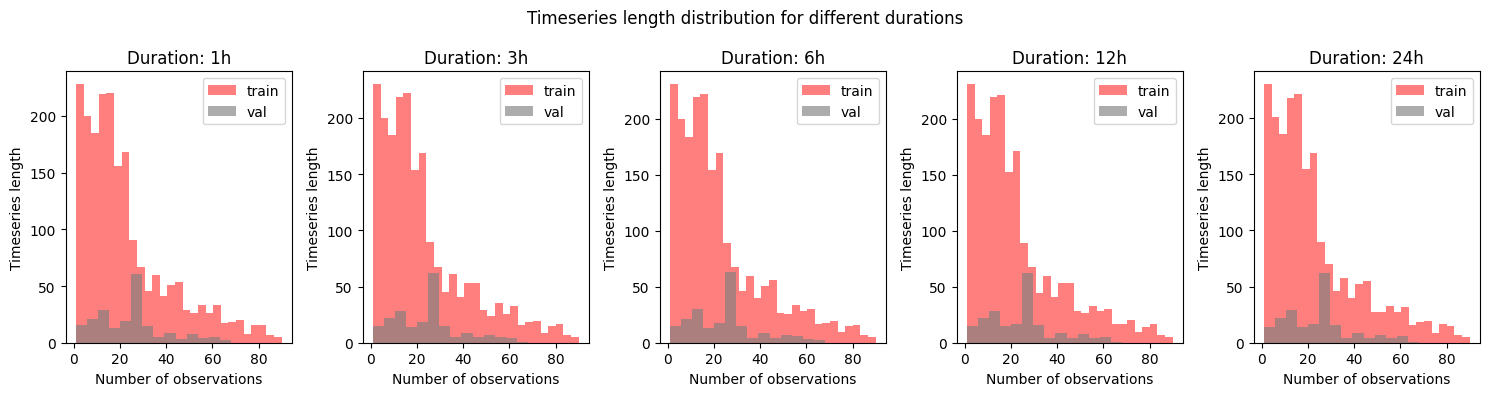

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns
fig.suptitle("Timeseries length distribution for different durations")

for i, duration in enumerate(DURATION):
    ax = axes[i]
    ax.hist(train_dfs[f'{duration}']['ID'].value_counts(), bins='auto', alpha=0.5, label='train', color='red')
    ax.hist(val_dfs[f'{duration}']['ID'].value_counts(), bins='auto', alpha=0.65, label='val', color='gray')
    ax.legend()
    ax.set_title(f"Duration: {duration}h")
    ax.set_xlabel("Number of observations")
    ax.set_ylabel("Timeseries length")

plt.tight_layout()
plt.show()

### MAP distribution for training and validation

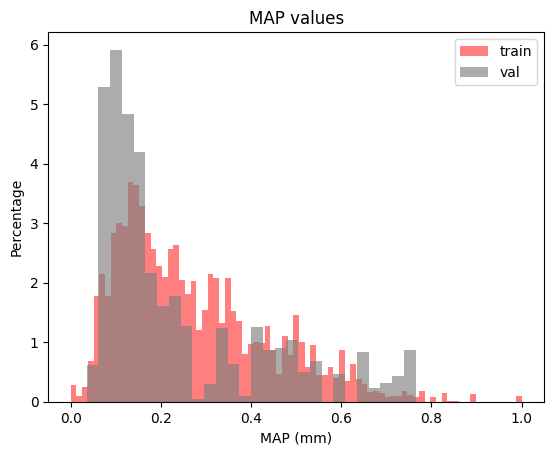

In [18]:
plt.hist(train_dfs['3']['MAP(mm)'], bins='auto', alpha=0.5, label='train', density=True, color='red')
plt.hist(val_dfs['3']['MAP(mm)'], bins='auto', alpha=0.65, label='val', density=True, color='gray')
plt.ylabel('Percentage')
plt.title('MAP values')
plt.xlabel('MAP (mm)')
plt.legend()
plt.show()

### Initial guesses

In [19]:
# plot the distribution of ams for all the durations
def get_initial_guesses(train_dfs, duration, distribution):
    ams = train_dfs[duration]['AMS']
    f = Fitter(ams, distributions=distribution)
    f.fit()
    #f.summary()
    a_guess, b_guess, _, _ = f.fitted_param[distribution]
    return a_guess, b_guess

## prepare data for training

In [20]:
print(train_dfs['3'].columns)

Index(['ID', 'AMS', 'mean_IdD', 'HMerit_mean(m)', 'HMerit_stdev(m)',
       'Slope_mean(deg)', 'Slope_stdev(deg)', 'Aspect_mean(deg)',
       'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)',
       'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)',
       'OrograTirr_mean(m)', 'OrograTirr_stdev(m)', 'OrograTirr_max(m)',
       'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [21]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
columns = train_dfs['1'].columns
input_columns = columns[3:]
output_column = 'AMS'
print('Input columns: ', input_columns)

Input columns:  Index(['HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [22]:
inputs_train = {}
outputs_train = {}
for duration in DURATION:
    inputs_train[f'{duration}'] = train_dfs[f'{duration}'][input_columns]
    outputs_train[f'{duration}'] = train_dfs[f'{duration}'][output_column]

inputs_val = {}
outputs_val = {}
for duration in DURATION:
    inputs_val[f'{duration}'] = val_dfs[f'{duration}'][input_columns]
    outputs_val[f'{duration}'] = val_dfs[f'{duration}'][output_column]

inputs_test = {}
outputs_test = {}
for duration in DURATION:
    inputs_test[f'{duration}'] = test_dfs[f'{duration}'][input_columns]
    outputs_test[f'{duration}'] = test_dfs[f'{duration}'][output_column]

In [23]:
inputs_train['3']

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,0.342699,0.438339,0.428583,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
1,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,0.342699,0.438339,0.428583,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
2,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,0.342699,0.438339,0.428583,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
3,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,0.342699,0.438339,0.428583,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
4,0.162167,0.139318,0.196981,0.203632,0.738690,0.727847,0.462398,0.273428,0.395750,0.340450,0.095174,0.256323,0.248748,0.302445,0.445455,0.014482,0.448583,0.065894,0.455494,0.327658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46655,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,0.398465,0.663196,0.673132,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
46656,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,0.398465,0.663196,0.673132,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
46657,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,0.398465,0.663196,0.673132,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
46658,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,0.398465,0.663196,0.673132,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404


# 2. Model definition

#### Bias model

In [24]:
def build_nn_beta_model_bias(input_shape, hidden, alpha_guess=1, beta_guess=1):
    alpha_guess = np.log(alpha_guess)
    beta_guess = np.log(beta_guess)

    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
        x = layers.BatchNormalization()(x)

    bias_initializer = tf.keras.initializers.Constant([alpha_guess, beta_guess])
    alpha_beta = layers.Dense(2, activation='exponential', bias_initializer=bias_initializer)(x)

    lf = lambda t: tfp.distributions.Beta(concentration0=t[:,1], concentration1=t[:,0], validate_args=True, allow_nan_stats=False)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

#### Bias Model with epsilon

In [25]:
def build_nn_beta_model_eps_bias(input_shape, hidden, alpha_guess=1, beta_guess=1):
    epsilon = 1e-3  # PROF: Aggiungete una piccola costante, in modo che i due parametri non possano essere troppo vicini allo 0, e.g. f(x) = \eps + \exp(x)

    alpha_guess = alpha_guess - epsilon
    beta_guess = beta_guess - epsilon

    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
        x = layers.BatchNormalization()(x)

    bias_initializer = tf.keras.initializers.Constant([alpha_guess, beta_guess])
    alpha_beta = layers.Dense(2, activation='relu', bias_initializer=bias_initializer)(x)

    lf = lambda t: tfp.distributions.Beta(concentration0= t[:,0:1] + epsilon, concentration1=t[:,1:2] + epsilon, validate_args=True, allow_nan_stats=False)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

#### Base model

In [26]:
def build_nn_beta_model(input_shape, hidden, alpha_guess=1, beta_guess=1):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
        x = layers.BatchNormalization()(x)
    alpha_beta = layers.Dense(2, activation='exponential')(x)

    lf = lambda t: tfp.distributions.Beta(concentration0=t[:,0:1], concentration1=t[:,1:2], validate_args=True, allow_nan_stats=False)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

#### Model with epsilon

In [27]:
def build_nn_beta_model_eps(input_shape, hidden, alpha_guess=1, beta_guess=1):
    epsilon = 1e-3  # PROF: Aggiungete una piccola costante, in modo che i due parametri non possano essere troppo vicini allo 0, e.g. f(x) = \eps + \exp(x)

    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
        x = layers.BatchNormalization()(x)
    alpha_beta = layers.Dense(2, activation='relu')(x)

    lf = lambda t: tfp.distributions.Beta(concentration0= t[:,0:1] + epsilon, concentration1=t[:,1:2] + epsilon, validate_args=True, allow_nan_stats=False)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

#### Custom loss

In [28]:
def custom_loss(y_true, dist):
    # LUCA: custom loss del tipo: -p(x) * log(p(x) + eps)

    prob = dist.prob(y_true)

    epsilon = 1e-3
    regularized_prob = prob + epsilon

    neg_log_prob_with_eps = tf.math.log(regularized_prob)

    return -prob * neg_log_prob_with_eps

In [29]:
# in termini pratici, invece di usare P(x = y) che non ha molto senso, 
# potete usare P(y-ε <= x <= y+ε), cosa che potete calcolare chiamando dist.cdf(y+ε) - dist.cdf(y-ε) se non sbaglio. 
def custom_loss_cdf(y_true, dist):
    epsilon = 1e-3

    cdf_plus = dist.cdf(y_true + epsilon)
    cdf_min = dist.cdf(y_true - epsilon)

    prob = cdf_plus - cdf_min

    neg_log_prob = -tf.math.log(prob + epsilon)

    return neg_log_prob

# MODELLO OK

In [30]:
def train_nn_model(model, X, y, batch_size, loss, lr,
        verbose=0, patience=10,
        validation_data=None, **fit_params):
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss)
    # Build the early stop callback
    cb = []
    if validation_split is not None:
        cb += [callbacks.EarlyStopping(patience=patience,
            restore_best_weights=True)]
    # Train the model
    history = model.fit(X, y, batch_size=batch_size, callbacks=cb,
            validation_data=validation_data,
            verbose=verbose, **fit_params)
    return history

def plot_training_history(history=None,
        figsize=None, print_final_scores=True):
    plt.figure(figsize=figsize)
    for metric in history.history.keys():
        plt.plot(history.history[metric], label=metric)
    if len(history.history.keys()) > 0:
        plt.legend()
    plt.xlabel('epochs')
    plt.grid(linestyle=':')
    plt.tight_layout()
    plt.show()
    if print_final_scores:
        trl = history.history["loss"][-1]
        s = f'Final loss: {trl:.4f} (training)'
        if 'val_loss' in history.history:
            vll = history.history["val_loss"][-1]
            s += f', {vll:.4f} (validation)'
        print(s)

In [31]:
def get_scores(y, y_pred, label, color):
    r2 = metrics.r2_score(y, y_pred)
    mae = metrics.mean_absolute_error(y, y_pred)

    ks_statistics, p_value = stats.ks_2samp(y, y_pred)

    plt.hist(y, bins='auto', alpha=0.4, label=label, density=True, color=color);
    #sns.kdeplot(y_pred, label='Estimated sample', fill=True)
    plt.hist(y_pred, bins='auto', alpha=0.6, label='Predicted', density=True, color='green');
    plt.legend()
    plt.show()

    return r2, mae, ks_statistics, p_value

#### duration 3

In [32]:
duration = '3'

X_train = inputs_train[duration].values
y_train  = outputs_train[duration].values
X_val = inputs_val[duration].values
y_val = outputs_val[duration].values
X_test = inputs_test[duration].values
y_test = outputs_test[duration].values

a_guess, b_guess = get_initial_guesses(train_dfs, duration, 'beta')

2024-02-13 10:51:26.902 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=43.177653)


Epoch 1/2
2917/2917 [==============================] - 20s 6ms/step - loss: 4.2401 - val_loss: 4.1138
Epoch 2/2
2917/2917 [==============================] - 15s 5ms/step - loss: 4.1435 - val_loss: 4.0887


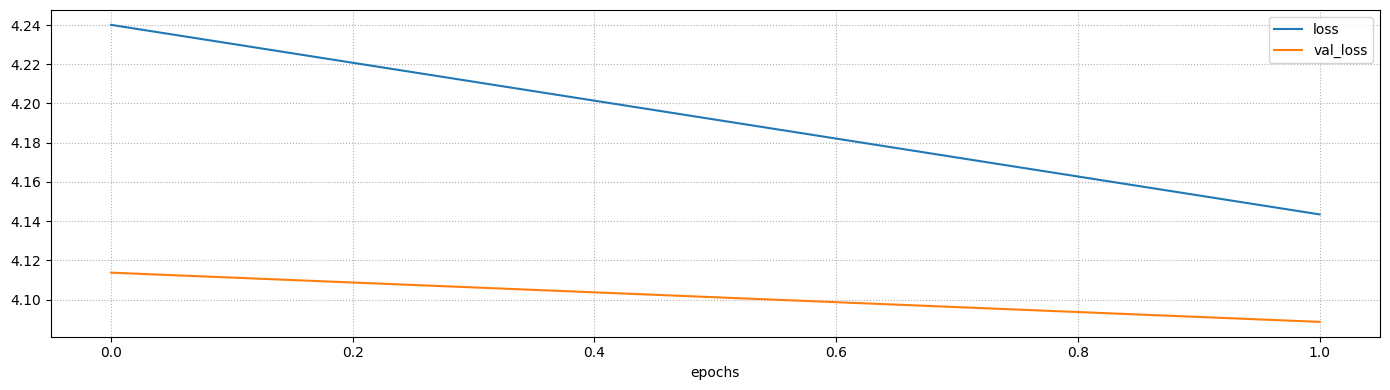

Final loss: 4.1435 (training), 4.0887 (validation)


In [33]:
batch_size = 16
epochs = 2
loss_fn = custom_loss_cdf
lr=1e-3
model = build_nn_beta_model_bias(input_shape=(20,), hidden=[], alpha_guess=a_guess, beta_guess=b_guess)
history = train_nn_model(model, X_train, y_train, batch_size, loss_fn, lr, verbose=1, patience=10, validation_data=(X_val, y_val), epochs=epochs)
plot_training_history(history, figsize=(14,4))

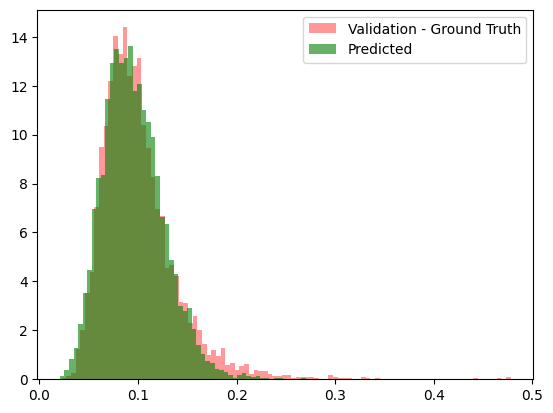

Validation:
R2: -0.67
MAE: 0.04
KS statistics: 0.04
P value: 0.00


In [34]:
num_samples = 1 #1 sample for each distribution
dist_val = model(X_val)
y_pred_val = dist_val.sample(num_samples).numpy().ravel()

r2_val, mae_val, ks_statistics, p_value = get_scores( y_val, y_pred_val, 'Validation - Ground Truth', 'red')
print('Validation:')
print(f'R2: {r2_val:.2f}')
print(f'MAE: {mae_val:.2f}')
print(f'KS statistics: {ks_statistics:.2f}')
print(f'P value: {p_value:.2f}')

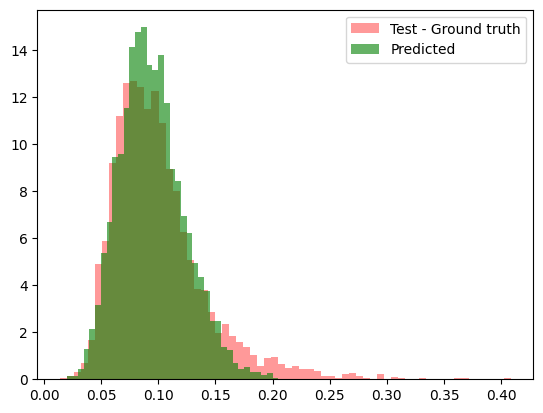

Test:
R2: -0.43
MAE: 0.04
KS statistics: 0.07
P value: 0.00


In [35]:
num_samples = 1 #1 sample for each distribution
dist_test = model(X_test)
y_pred_test = dist_test.sample(num_samples).numpy().ravel()

r2_test, mae_test, ks_statistics, p_value = get_scores(y_test, y_pred_test, 'Test - Ground truth', 'red')
print('Test:')
print(f'R2: {r2_test:.2f}')
print(f'MAE: {mae_test:.2f}')
print(f'KS statistics: {ks_statistics:.2f}')
print(f'P value: {p_value:.2f}')

In [72]:
#compute pearson correlation
pearson_corr = np.corrcoef(y_test, y_pred_test)
print(f'Pearson correlation: {pearson_corr[0,1]:.2f}')

Pearson correlation: 0.04


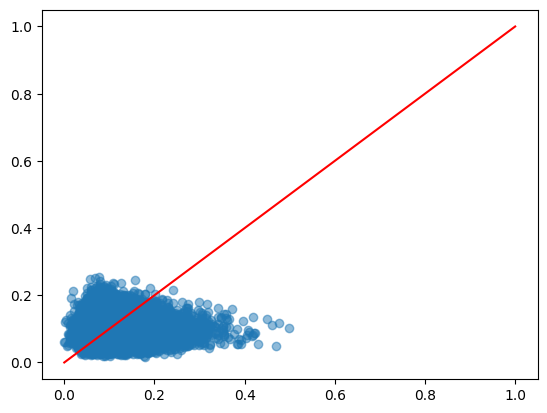

In [71]:
num_samples = 1 #1 sample for each distribution
dist_train = model(X_train)
y_pred_train = dist_train.sample(num_samples).numpy().ravel()
plt.scatter(y_train, y_pred_train, alpha=0.5)
#plotta bisettrice
plt.plot([0, 1], [0, 1], color='red')


# Predictions

In [42]:
def plot_series(data, labels=None,
                    windows=None,
                    predictions=None,
                    highlights=None,
                    val_start=None,
                    test_start=None,
                    figsize=None,
                    show_sampling_points=False,
                    show_markers=False,
                    filled_version=None,
                    std=None,
                    ci=None,
                    title=None,
                    ylim=None):
    # Open a new figure
    plt.figure(figsize=figsize)
    # Plot data
    if not show_markers:
        plt.plot(data.index, data.values, zorder=0)
    else:
        plt.plot(data.index, data.values, zorder=0,
                marker='.', markersize=3)
    if filled_version is not None:
        filled = filled_version.copy()
        filled[~data['value'].isnull()] = np.nan
        plt.scatter(filled.index, filled,
                marker='.', c='tab:orange', s=5);
    if show_sampling_points:
        vmin = data.min()
        lvl = np.full(len(data.index), vmin)
        plt.scatter(data.index, lvl, marker='.',
                c='tab:red', s=5)
    # Plot standard deviations
    if std is not None:
        lb = data.values.ravel() - std.values.ravel()
        ub = data.values.ravel() + std.values.ravel()
        plt.fill_between(data.index, lb, ub, alpha=0.3, label='+/- std')
    # Plot confidence intervals
    if ci is not None:
        lb = ci[0]#.values.ravel()
        ub = ci[1]#.values.ravel()
        plt.fill_between(data.index, lb, ub, alpha=0.3, label='C.I.')
    # Rotated x ticks
    plt.xticks(rotation=45)
    # Plot labels
    if labels is not None:
        plt.scatter(labels.values, data.loc[labels],
                    color='red', zorder=2, s=5)
    # Plot windows
    if windows is not None:
        for _, wdw in windows.iterrows():
            plt.axvspan(wdw['begin'], wdw['end'],
                        color='red', alpha=0.3, zorder=1)
    # Plot training data
    if val_start is not None:
        plt.axvspan(data.index[0], val_start,
                    color='blue', alpha=0.1, zorder=-1)
    if val_start is None and test_start is not None:
        plt.axvspan(data.index[0], test_start,
                    color='blue', alpha=0.1, zorder=-1)
    if val_start is not None:
        plt.axvspan(val_start, test_start,
                    color='red', alpha=0.1, zorder=-1)
    if test_start is not None:
        plt.axvspan(test_start, data.index[-1],
                    color='green', alpha=0.3, zorder=0)
    # Predictions
    if predictions is not None:
        plt.scatter(predictions.values, data.loc[predictions],
                    color='black', alpha=.4, zorder=3,
                    s=5)
    # Force y limits
    if ylim is not None:
        plt.ylim(*ylim)
    plt.grid(linestyle=':')
    plt.title(title)
    plt.tight_layout()


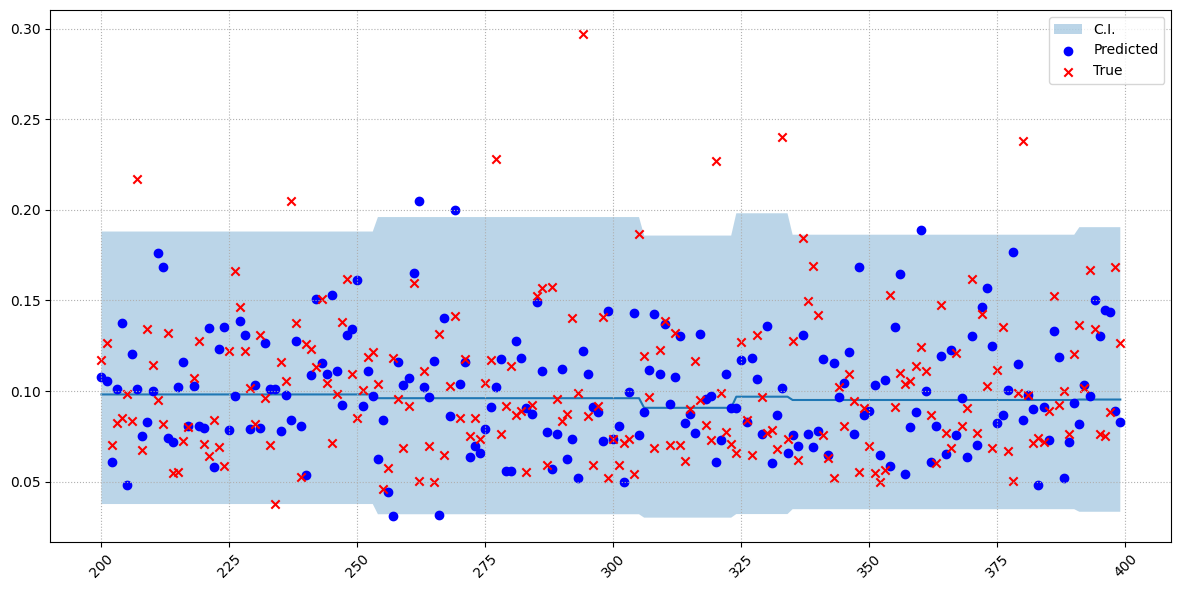

Percentage of true values inside the confidence interval: 94.39%
Percentage of pred values inside the confidence interval: 98.99%


In [62]:
da = 200
a = 400

alpha_param = dist_test.concentration1
beta_param = dist_test.concentration0
confidence = 0.99

lb, ub = stats.beta.interval(confidence, a=alpha_param, b=beta_param)
pred_test_mean = dist_test.mean().numpy().ravel()

plot_series(pd.Series(index=inputs_test[duration][da:a].index, data=pred_test_mean[da:a]), ci=(lb[da:a],ub[da:a]), figsize=(12,6))
plt.scatter(inputs_test[duration][da:a].index, y_pred_test[da:a], marker='o', color='blue', label='Predicted');
plt.scatter(inputs_test[duration][da:a].index, y_test[da:a], marker='x', color='red', label='True');
plt.legend()
plt.show()

# count how many times the true value is inside the confidence interval
count_true = 0
count_pred = 0
for i in range(len(y_test)):
    if lb[i] <= y_test[i] <= ub[i]:
        count_true += 1
    if lb[i] <= y_pred_test[i] <= ub[i]:
        count_pred += 1
print(f'Percentage of true values inside the confidence interval: {count_true/len(y_test)*100:.2f}%')
print(f'Percentage of pred values inside the confidence interval: {count_pred/len(y_test)*100:.2f}%')

In [63]:
# count true positive, true negative, false positive, false negative
tp = 0
tn = 0
fp = 0
fn = 0
 
for i in range(len(y_test)):
    if lb[i] <= y_test[i] <= ub[i]:
        if lb[i] <= y_pred_test[i] <= ub[i]:
            tp += 1
        else:
            fn += 1
    else:
        if lb[i] <= y_pred_test[i] <= ub[i]:
            fp += 1
        else:
            tn += 1
 
# print percentages
print(f'True positive: {tp/len(y_test)*100:.2f}%')
print(f'True negative: {tn/len(y_test)*100:.2f}%')
print(f'False positive: {fp/len(y_test)*100:.2f}%')
print(f'False negative: {fn/len(y_test)*100:.2f}%')


True positive: 93.42%
True negative: 0.03%
False positive: 5.58%
False negative: 0.97%
